Autoencoder: 
- unsupervised ML
- special type of NN that encodes (compresses) a dim reduced format of the data and then decodes (reconstructs) it back into an image --> want to minimise reconstruction error
    - determines latent variables for most efficient deconstruxn/reconstruxn

Let's use autoencoders to detect anomalies in ECG data.

## ECG Data Preprocessing

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model

In [ ]:
# load dataset
fpath = '../Data/ecg.csv'
df = pd.read_csv(fpath, header=None)
df.head()
df.shape

(4998, 141)

In [ ]:
# split feature and target data
# last col is target labels; no col names --> use integer indexing
# .iloc(row:row, col:col) 
data = df.iloc[:, 0:-1]
labels = df.iloc[:, -1] 
print(data.shape, labels.shape)


(4998, 140) (4998,)


In [48]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=40)

After splitting, will normalise the data. MinMax or Standard scaler? 
https://arxiv.org/pdf/2311.04229

In [83]:
# normalise
# transform on train data, fit on train + test data
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [84]:
# convert labels to boolean for easier target separation 
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# normal ECG train + test data
norm_train = X_train[y_train]
norm_test = X_test[y_test]
# abnormal ECG train + test data 
abn_train = X_train[~y_train]
abn_test = X_test[~y_test]

# validation step
len(abn_train) + len(norm_train) == len(X_train)

True

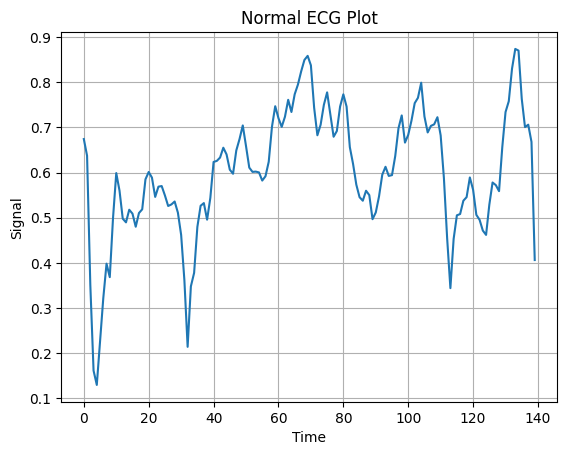

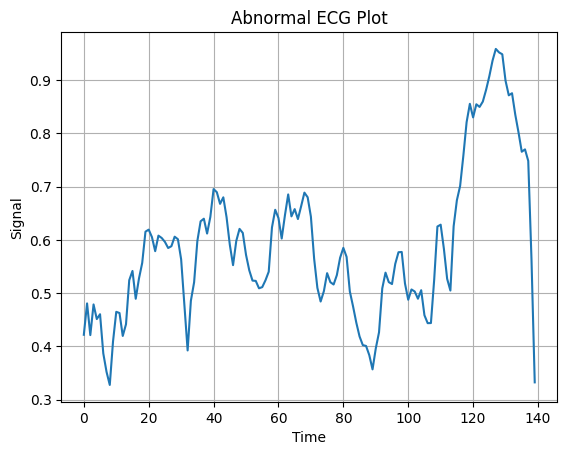

In [94]:
# plot the ECG data
# x = time, y = ECG signal over 140 timepoints
plt.plot(np.arange(140), norm_train[3]) # select a single subject row
plt.grid()
plt.title('Normal ECG Plot')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

plt.plot(np.arange(140), abn_train[2])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Abnormal ECG Plot')
plt.show()

# Run Model

An autoencoder tries to recreate the input after dimension-reduced storage. \
We want the autoencoder to detect anomalies in the data. \
**reconstruction error** = difference between input and decoded output.\
We will train the autoencoder on only normal ECG data, but present both normal and anomalous ECG test data \
--> reconstruction error should be larger for anomolous ECG data since the autoencoder is not trained for this data shape, resulting in poor reconstruction performance.

We will thus set a reconstruction error threshold to determine 'normal' or 'anomaly' label assignment. 

## Functional API Model
Functional NN API used to describe layers with common Keras functions and connect input and output. Often used for autoencoders. 

Keras Functional API model \
`input_layer = ECG_input_channel(shape=(num_timesteps, channel_num))`\
Clean the raw ECG data \
Conv1D() convolution, filters = number of features to filter down to \
Must connect to input layer  
`cleaned_data = Conv1D(filters = 32//64, kernel_size= , ...)(input_layer)`\
Encode the data\
`latent_layer = Dense()(cleaned_data)`\
Decode the data; mirrors encoding\
`decoder_output = UpSampling1D(size =)(latent_layer) # repeats each temporal step 'size' times`

Full model instantiation \
`autoencoder = Model(input_layer, decoder_output)` \
Encoder-only model instantiation; do not perform reconstruction step \
`encoder_only = Model(input_layer, latent_layer)`

In [ ]:
# # Keras Functional API model
# input_layer = ECG_input_channel(shape=(num_timesteps, channel_num))
# # clean the raw ECG data
#     # Conv1D convolution, filters = number of features to filter down to
#     # must connect to input layer  
# cleaned_data = Conv1D(filters = 32//64, kernel_size= , ...)(input_layer)
# # encode the data
# latent_layer = Dense()(cleaned_data)
# # decode the data; mirrors encoding
# decoder_output = UpSampling1D(size =)(latent_layer) # repeats each temporal step 'size' times

# # full model instantiation
# autoencoder = Model(input_layer, decoder_output)
# # encoder-only model instantiation; do not perform reconstruction step 
# encoder_only = Model(input_layer, latent_layer)

## Model Subclassing
*Sequential API* = like simple end-to-end pipeline with only 1 channel, so it cannot manage multiple inputs/outputs. 

The following uses the Sequential API, but subclassing allows manual passing bw encoder + decoder layers, affording better control. This method requires writing logic of the class.\
Sequential Documentation: https://keras.io/guides/sequential_model/

In [ ]:
class Autoencoder(Model): # using Keras Model class as template
    def __init__(self): # instantiation 
        super(Autoencoder, self).__init__() # calls Model's instantiation
        self.encoder = tf.keras.Sequential([
            # layering to compress fetaures to 32 -> 16 -> 8
            layers.Dense(32, activation='relu'), 
            # relu = Rectified Linear Unit; converts negatives to 0; improves training clarity + speed  
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
            # layering to reconstruct; final layer has same # of features as input
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            # started w 140 features, final layers 140 
            layers.Dense(140, activation='sigmoid') 
            # output as Sigmoid [0,1] 
            # --> (all data is 0 to 1 bc normalization step)

        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

decoder output activation=:
- sigmoid [0 1] (0-1 normalised data)
- tanh [-1 1]
- NA for linear output/any range output  (standardised data)
